# Use LP based Adaptive Shadow Ban Policy



In [ ]:
#!pip install control

In [1]:
import numpy as np
import control.optimal as obc
import control as ct
from pyoptsparse import  Optimization, OPT
import pyoptsparse as pos
import scipy.sparse as sparse
from scipy.sparse import coo_matrix, csr_matrix, diags, identity

from scipy.optimize import linprog

import matplotlib.pyplot as plt
import scripts.shadowban_pyoptsparse as sb
from scripts.shadowban_adaptive import *
from scripts.opinion_visualization import *
from scripts.load_data import * # load Twitter network
from scripts.class_dynamics import * # class for opinion dynamics simulation
import networkx as nx


import pandas as pd
import time
import seaborn as sns
from datetime import datetime


# Initialization

## Load Network

For your network `G` you need the following node features
   1. `rates` = array of posting rate of each node
   2. `opinions0` = array of initial opinions of each node

### Load Synthetic Network

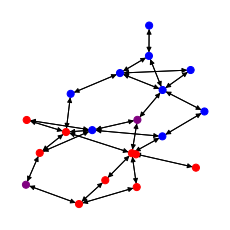

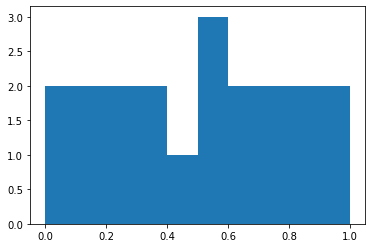

In [2]:
n0 = 20
nc = int(n0/2)
sizes = [nc, nc]
p0, p1 = 8/n0, 1/n0
probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
    G.nodes[i]['rate'] = 1
    G.nodes[i+nc]['rate'] = 1
fig = draw_network(G)

A = nx.adjacency_matrix(G)
A = A.tocoo()
assert n0 == A.shape[0]  #number of nodes in network should equal shape of A
rates = np.array([G.nodes[v]["rate"] for v in G.nodes()])  #posting rates of nodes
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])  #initial opinions of nodes

plt.hist(opinions0)
plt.show()

network_params = {'A':A, 'rates':rates, 'opinions0':opinions0}

### Load Twitter Network

File name = GiletsJaunes_sample_02_agent.csv
Nodes in df = 2002 including users, bots, agents
Nodes in G_bots = 1881 including connected users, connected bots
. Connected users = 1732
. Connected bots = 149 = 8% of connected nodes
. Stubborn users = 77 = 4% of connected users
. Mean user rate = 1.81 tweets/day
. Mean bot rate = 3.27 tweets/day
. Bots targets = 569 user-times = 309 unique users = 18% of connected users


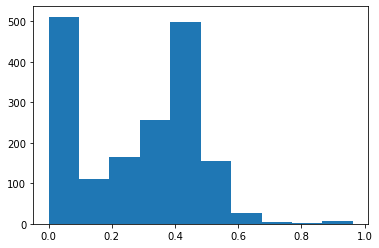

In [5]:
fname = "GiletsJaunes_sample_02_agent.csv" # "Brexit_sample_02_agent.csv"
G, network_params = G_to_params(fname) #{'A':A, 'rates':rates, 'opinions0':opinions0}

## Set Simulation and Optimization Parameters

In [6]:
#simulation parameters
tau = 0.1
omega = 1

Tf = 10     #final time of simulator
npts_eval = 100  #number of time discretization points for simulation
npts = 3
assert npts < npts_eval

#optimization parameters 
smax = 0.5  #max strength of shadow banning at any time
OBJECTIVE = 'MEAN'  #integral cost type

assert OBJECTIVE in ['MEAN','VARMIN','VARMAX']

## Create params dictionary for problem

In [7]:
nv = G.number_of_nodes()
ne = G.number_of_edges()

#adjacency matrix of network
# A = nx.adjacency_matrix(G)
# A = A.tocoo()
E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge

ne = G.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G.nodes():
    output_names.append(f"theta{v}")
    
# assert nv == A.shape[0]  #number of nodes in network should equal shape of A
assert ne == E.shape[1]  #number of edges in network should equal columns of E


#parameters of network model
# params = {'A':A,'E':E,'rates':rates,'tau':tau,'omega':omega, 'opinions0':opinions0,
#          'npts_eval':npts_eval, 'Tf':Tf,'smax':smax,
#           'OBJECTIVE':OBJECTIVE, 'npts':npts}
additional_params = {'tau': tau, 'omega': omega, 'npts_eval': npts_eval, 'Tf': Tf, 'smax': smax, 'OBJECTIVE': OBJECTIVE, 'npts': npts,'E':E}

params = {**network_params, **additional_params} #parameters of network model
params


{'A': <1732x1732 sparse matrix of type '<class 'numpy.int64'>'
 	with 10660 stored elements in COOrdinate format>,
 'rates': array([0.33333333, 1.26666667, 0.36666667, ..., 0.6       , 0.1       ,
        0.36666667]),
 'opinions0': array([0.        , 0.36858494, 0.36858359, ..., 0.95690314, 0.21756274,
        0.        ]),
 'tau': 0.1,
 'omega': 1,
 'npts_eval': 100,
 'Tf': 10,
 'smax': 0.5,
 'OBJECTIVE': 'MEAN',
 'npts': 3,
 'E': <1732x10660 sparse matrix of type '<class 'numpy.float64'>'
 	with 10660 stored elements in COOrdinate format>}

# Define Input/Output Systems

In [22]:
sys_no_agent = ct.NonlinearIOSystem(
        updfcn =sb.sys_update, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network no agent', params=params)

sys_lp = ct.NonlinearIOSystem(
        updfcn =sys_update_lp, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network lp', params=params)

In [24]:
ct.optimal.state_range_constraint(sys_no_agent, np.zeros(nv), np.ones(nv))

(scipy.optimize._constraints.LinearConstraint,
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]))

# Opinions with no Shadow Banning

In [20]:
%%time
T, Opinions_no_agent, _ = sb.simulate_opinions(params, sys_no_agent)
obj_no_agent = sb.cost_sim(OBJECTIVE, Opinions_no_agent)

CPU times: user 44.6 s, sys: 982 ms, total: 45.6 s
Wall time: 31.8 s


# Opinions with LP Shadow Banning

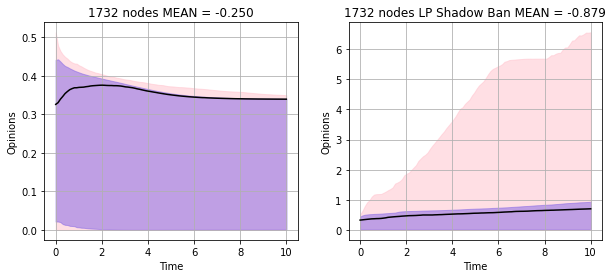

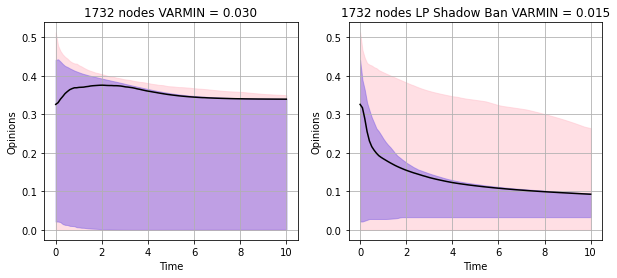

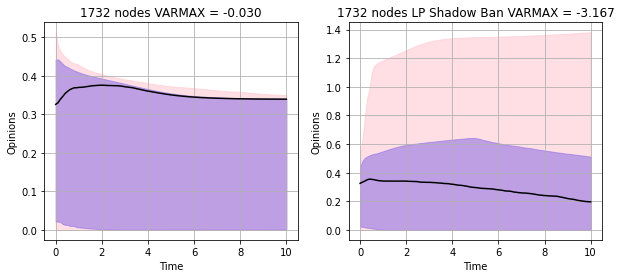

CPU times: user 4min, sys: 49.3 s, total: 4min 49s
Wall time: 4min 33s


In [23]:
%%time

for OBJECTIVE in ['MEAN','VARMIN','VARMAX']:
    params['OBJECTIVE'] = OBJECTIVE
    obj_no_agent = sb.cost_sim(OBJECTIVE, Opinions_no_agent)
    #LP shadow banning 
    T, Opinions_lp, _ = sb.simulate_opinions(params, sys_lp)
    obj_lp = sb.cost_sim(OBJECTIVE, Opinions_lp)

    fig = plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plot_opinion_quantiles(T, Opinions_no_agent)
#     plot_opinions(T, Opinions_no_agent)

    plt.title(f"{nv} nodes {OBJECTIVE} = {obj_no_agent:.3f}")
    plt.subplot(1,2,2)
    plot_opinion_quantiles(T, Opinions_lp)
#     plot_opinions(T, Opinions_lp)
    plt.title(f"{nv} nodes LP Shadow Ban {OBJECTIVE} = {obj_lp:.3f}")
    #plt.savefig(f"figures/shadowban_{OBJECTIVE}_{nv}_node_sbm.jpeg")
    plt.show()